In [47]:
# imports for analysis
import numpy as np
from scipy.io import loadmat
from collections import defaultdict
from nilearn.glm.first_level import FirstLevelModel

# imports for clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# imports for data loading, processing and analysis
from utils.io import get_args, get_results_dir, save_args, load_data
from utils.preprocessing import set_get_timeseries, build_sub_run_df, convert_df_to_desMat, add_VTC_get_breaks, exclude_irrelevant_VTC_TRs
from utils.nilearn_analysis import fit_edge_flm

In [48]:
# Set rng for replication
np.random.seed(2022)

In [49]:
# ARGUMENTS
NTPS_FIR = 31 # how many timepoints to investigate using FIR
args = get_args(['-use_rois']) # sets many default arguments, can be changed by passing in a list of arguments

# Set up directories, load data
results_dir = get_results_dir(args)
save_args(args, results_dir)

ridx, cidx = np.tril_indices(args.nROI, -1)
get_timeseries = set_get_timeseries(args, ridx, cidx)  # set the type of timeseries to use, ROI or edge

timeseries_data, sub_file_map, sublist, ntr_tossed = load_data(args)

In [50]:
# PREPROCESS BEHAV DATA, MAKE DESIGN MATRICES
des_mat_dict = defaultdict(list)
fitable_timeseries = defaultdict(list)
for sidx, sub in enumerate(sublist):
    
    sub_files = sub_file_map[sidx]

    for runidx, sub_file in enumerate(sub_files[:1]): # ONLY TAKING THE FIRST SESSION FOR FIR 
        sub_trs = np.arange(timeseries_data[sidx][runidx].shape[0])*args.t_r
        
        sub_run_df = build_sub_run_df(loadmat(sub_file), ntr_tossed, args)
        
        sub_run_df, (break_onsets, break_offsets, break_durations) = add_VTC_get_breaks(sub_run_df, args)

        sub_run_desmat = convert_df_to_desMat(
                sub_run_df,
                sub_trs,
                model=args.model,
                VTC_shift = args.VTC_shift,
                break_durations=break_durations,
                hrf_model='fir',
                fir_delays = np.arange(NTPS_FIR)
            )
        
            
        curr_timeseries = get_timeseries(timeseries_data[sidx][runidx])
            
        sub_run_desmat, curr_timeseries = exclude_irrelevant_VTC_TRs(sub_run_desmat, curr_timeseries, args, break_onsets, break_offsets)

        des_mat_dict[sub].append(sub_run_desmat)    
        fitable_timeseries[sub].append(curr_timeseries)

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' colum

In [51]:
# FIR ESTIMATES
nsites = args.nROI if args.use_rois else len(ridx)
betas = np.full((len(des_mat_dict.keys()), nsites, NTPS_FIR), np.nan)

for sidx, sub in enumerate(des_mat_dict.keys()):
    if len(des_mat_dict[sub]): # sub17, VTC_trialTypes model doesn't have any full design matrices
        fitted_flm = fit_edge_flm(
            FirstLevelModel(t_r=args.t_r, signal_scaling=args.signal_scaling, noise_model=args.glm_noise_model),
            run_Ys=fitable_timeseries[sub],
            design_matrices=des_mat_dict[sub],
        )
        
        labels = fitted_flm.labels_[0]
        regression_result = fitted_flm.results_[0]


        for delay in range(NTPS_FIR):
            con_val = fitted_flm.design_matrices_[0].columns.isin([f'probe_success_delay_{delay}', f'probe_fail_delay_{delay}'])

            for label_ in regression_result:
                label_mask = labels == label_

                betas[sidx, label_mask, delay] = np.dot(con_val, regression_result[label_].theta)
        


In [52]:
np.save('results/betas/edges', betas)

## Reload betas if not computing

In [53]:
betas = np.load('results/betas/edges.npy')
betas_means = betas.mean(0)

# Using k-means and elbowing to find the right number of clusters

In [54]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

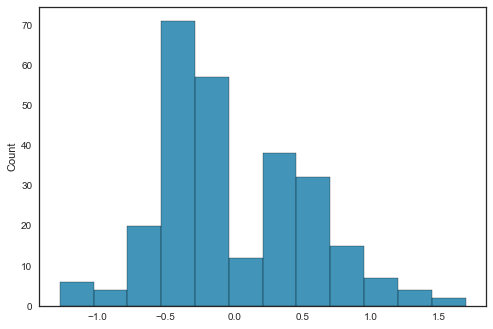

In [55]:
# flipping signs based on largest value across the timeseries, for each edge

lowest_vals = betas_means.min(1)
highest_vals = betas_means.max(1)
largest_vals = np.where(np.abs(lowest_vals)>np.abs(highest_vals), lowest_vals, highest_vals)
_ = sns.histplot(largest_vals)
plt.show()
plt.close()

betas_magSigned = betas_means / np.sign(largest_vals)[:, np.newaxis]

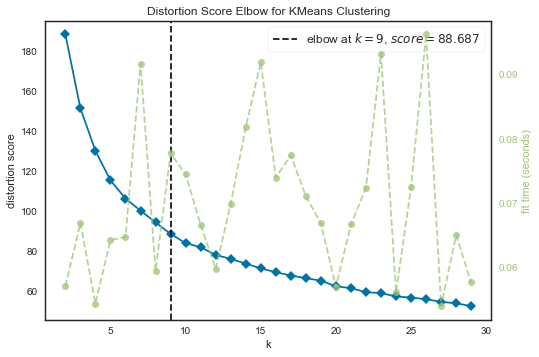

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(betas_magSigned)        # Fit data to visualizer
visualizer.show() 

In [57]:
model = KMeans(n_clusters=9)
model.fit(betas_magSigned)

KMeans(n_clusters=9)

In [58]:
yhat = model.predict(betas_magSigned)
clusters = sorted(np.unique(yhat))

In [59]:
cluster_sizes = np.full(len(clusters), np.nan)
for cluster in clusters:
    cluster_sizes[cluster] = np.sum(yhat == cluster)

In [60]:
def get_plot_line(a):
    """
    Takes in 2D array of shape [subjects,time points].
    Returns mean, and upper/lower SEM lines.
    """
    mean = np.nanmean(a,0)
    std = np.std(a,0)
    upper,lower = mean + std, mean - std
    return mean, upper, lower

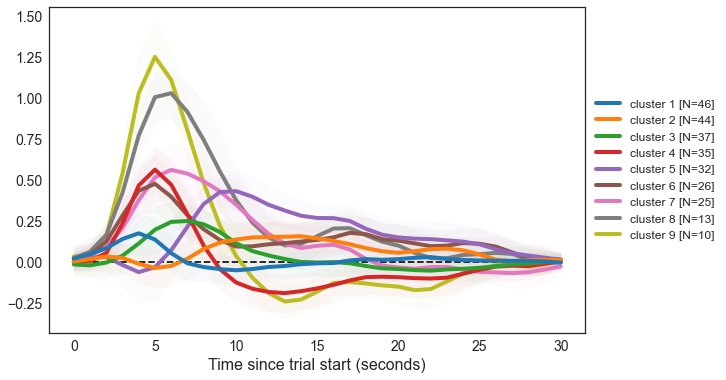

In [61]:
fig = plt.figure(figsize=(12,6))
plt.style.use("seaborn-white")

plt.plot(np.zeros(NTPS_FIR), color='k', linestyle='--')

for cid, cluster in enumerate(np.argsort(cluster_sizes)):
    cid = 9-cid #
    med, upper, lower = get_plot_line(betas_magSigned[yhat == cluster, :])
    
    line, = plt.plot(med, color=colors[cid-1], linewidth=4)
    line.set_label(f'cluster {cid} [N={sum(yhat==cluster)}]')
    plt.fill_between(np.arange(NTPS_FIR),upper,lower, color=colors[cid-1],alpha=.03)
    
plt.xlabel('Time since trial start (seconds)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax=plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.savefig(f"results/figures/FIR_estimates_edges.png", bbox_inches="tight", dpi=300, transparent=True)
plt.show()
plt.close()

In [62]:
13+13+21+32+36+48

163

In [63]:
163/268

0.6082089552238806

In [64]:
23+26+56

105

In [65]:
105/268

0.3917910447761194

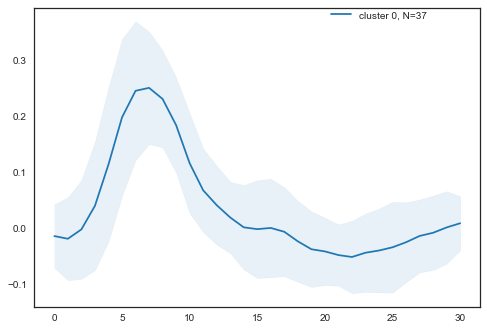

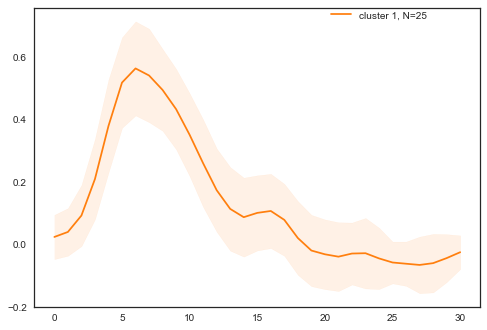

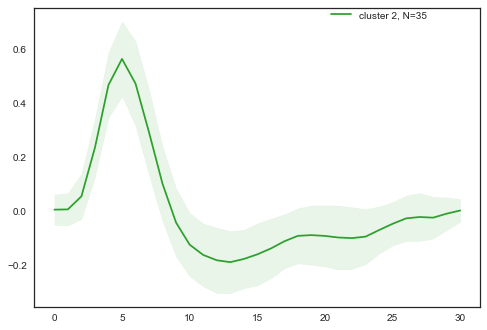

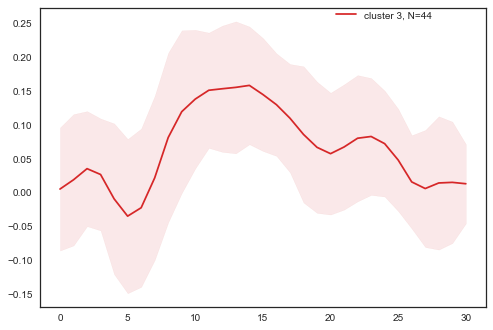

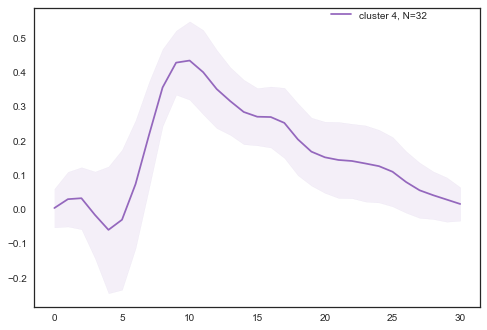

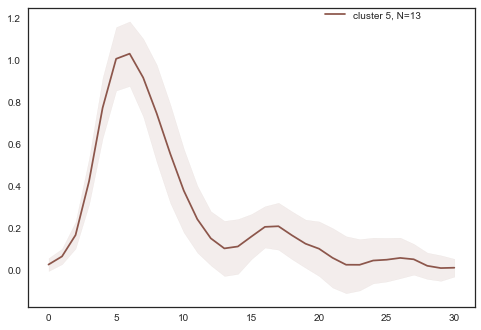

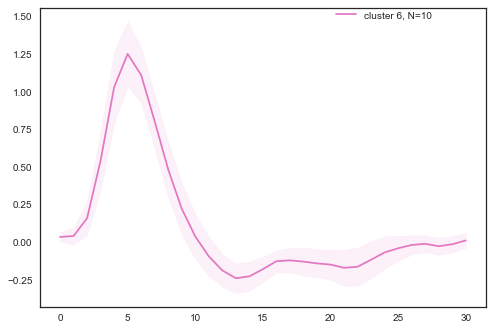

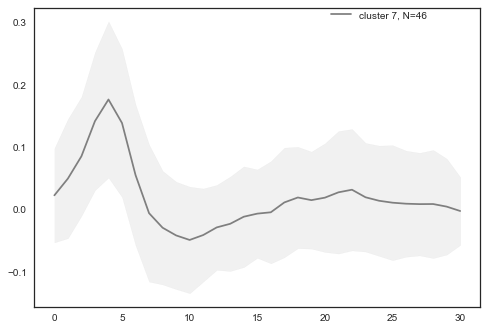

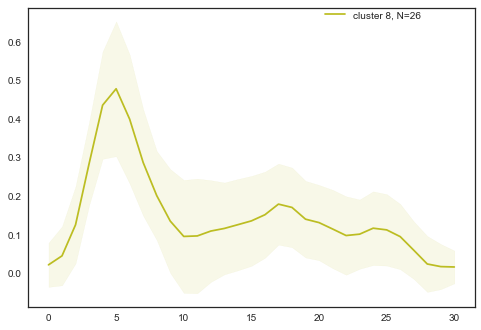

In [66]:
for cluster in sorted(clusters):
    med, upper, lower = get_plot_line(betas_magSigned[yhat == cluster, :])
    
    line, = plt.plot(med, color=colors[cluster])
    line.set_label(f'cluster {cluster}, N={sum(yhat==cluster)}')
    plt.fill_between(np.arange(NTPS_FIR),upper,lower, color=colors[cluster],alpha=.1)
    
    _ = plt.legend(bbox_to_anchor=(.9, 1.02))
    plt.show()
    plt.close()

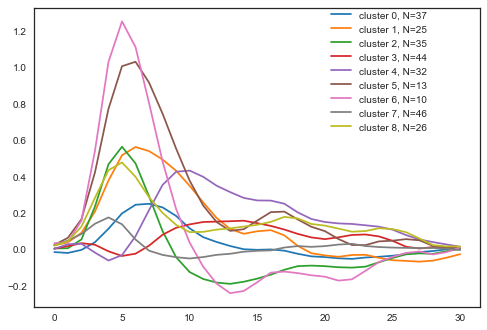

In [67]:
for cluster in sorted(clusters):
    line, = plt.plot(betas_magSigned[yhat == cluster, :].mean(0), color=colors[cluster])
    line.set_label(f'cluster {cluster}, N={sum(yhat==cluster)}')
_ = plt.legend(bbox_to_anchor=(.9, 1.02))
plt.show()
plt.close()